In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import gymnasium as gym
import gym_trading_env
from gym_trading_env.environments import (
    dynamic_feature_last_position_taken,
    dynamic_feature_real_position  # you can import it if you ever need it
)

from RLTrade.agent import DQNAgent, XGBoostAgent
from RLTrade.utils import (
    stationary_dgp, 
    make_ohlc,
    FeatureEngineering
)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

### Details of the simulation
Consider two cointegrated price series $X_t = X_{t-1} + e_t; e_t \sim N(0, \sigma^2)$ is a random walk; and $Y_t = X_t + \epsilon_t$ where $\epsilon_t$ is a stationary mean reverting signal generated by Ornstein–Uhlenbeck process, it is basically an autoregressive noise. 

$X_t$ and $Y_t$ are both non-stationary and integrated of order 1 - I(1).

But the resultant portfolio $Y - X = \epsilon_t$ is a stationary process - I(0) and is mean reverting

### Details of the environment and trading agent
This is the most simplified case, the agent sees only two features, i.e. the state is 2-D:
- the close price of today
- the position taken today

It then performs 1 of the 3 actions precisely at the market close time today (or at the market open time tomorrow, assuming there is no after hours)
- -1: SHORT
- 0: EXIT
- 1: LONG

The reward of this environment is the log-return of portfolio value at each time step, so the model is simply optimised for maximising portfolio value at each time step.

The agents are model-based Q Learning algorithms, i.e. they will use an internal model to estimate to Q-value for each (state, action)-pair. And they will choose actions based on Q-value using epsilon-greedy algoritm during training, and greedy algorithm during inference/evaluation.

Two types of common model are used:
- XGBoost: Expect to learn quicker but may overfit, also less feature engineering needed
- Fully-connected NN: Expect to generalise better but requires more attention to feature engineering and model architecture

In [2]:
x0, mu_epsilon = 100, 200

N, window, stride = 100000, 24, 24  # simulation with ohlc
# N, window, stride = 10000, 1, 1  # simulation with tick data

train_set_random_state = 42
x_c, y_c = stationary_dgp(N=N, x0=x0, mu=mu_epsilon, random_state=train_set_random_state)
y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
# spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

In [3]:
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02,
    row_heights=[0.33, 0.33, 0.34],
    subplot_titles=["Candlestick Chart: X", "Candlestick Chart: Y", "Candlestick Chart: Y - X"]
)

# Row 1: X candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=x_o,
    high=x_h,
    low=x_l,
    close=x_c,
    name="X"
), row=1, col=1)

# Row 2: Y candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=y_o,
    high=y_h,
    low=y_l,
    close=y_c,
    name="Y"
), row=2, col=1)

# Row 3: Y - X candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=spread_o,
    high=spread_h,
    low=spread_l,
    close=spread_c,
    name="Y - X"
), row=3, col=1)

# Layout adjustments
fig.update_layout(
    height=600,
    xaxis_rangeslider_visible=False,   # Row 1
    xaxis2_rangeslider_visible=False,  # Row 2
    xaxis3_rangeslider_visible=False,  # Row 3
    showlegend=False,
    margin=dict(t=40, b=20)
)

fig.show()

0.002199959074487561 0.0012822398621351264


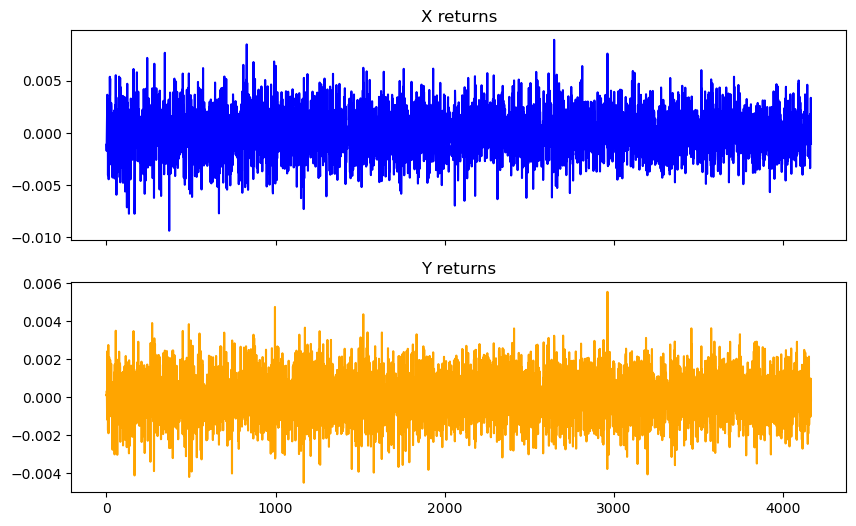

In [4]:
# plot volatility of X and Y
x_rets = np.diff(x_c) / x_c[:-1]
y_rets = np.diff(y_c) / y_c[:-1]
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axs[0].plot(x_rets, label='X returns', color='blue')
axs[0].set_title('X returns')
axs[1].plot(y_rets, label='Y returns', color='orange')
axs[1].set_title('Y returns')

print(np.std(x_rets), np.std(y_rets))

In [5]:
# confirm the x, y pair is correlated, i.e. Z_t = Y_t - beta * X_t can be fitted with a significant beta
x_ols = sm.add_constant(x_c)
ols = sm.OLS(y_c, x_ols).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.197e+06
Date:                Thu, 15 May 2025   Prob (F-statistic):               0.00
Time:                        16:18:40   Log-Likelihood:                 187.05
No. Observations:                4166   AIC:                            -370.1
Df Residuals:                    4164   BIC:                            -357.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        199.9724      0.042   4715.075      0.0

In [6]:
# Confirm the spread (residual of Y - X) is stationary
adfuller_test = adfuller(spread_c)
print(f'ADF Statistic: {adfuller_test[0]}')
print(f'p-value: {adfuller_test[1]}')
print('Is the spread stationary? {}'.format('Yes' if adfuller_test[1] < 0.05 else 'No'))

ADF Statistic: -59.2862851067775
p-value: 0.0
Is the spread stationary? Yes


### Demo: Using Deep Q-Learning on the spread (with feature engineering of moving window mean correction)

In [7]:
feature_config = [
    {'type': 'rolling_mean_corrected',
     'params': {
       'cols': ['close'],
       'window': 100,
     }},
]

df_train = df.copy()
fe = FeatureEngineering(df_train)
df_train = fe.build_features(feature_config)
df_train

,open,high,low,close,feature_close_rolling_mean_corrected
2020-01-01,199.986174,200.549237,199.319746,199.802509,0.000000
2020-01-02,199.645954,200.435982,199.612046,199.948100,0.072796
2020-01-03,199.979395,200.403368,199.656875,200.142213,0.177939
2020-01-04,200.206174,200.651949,199.902046,200.274014,0.232305
2020-01-05,200.122038,200.695065,199.800625,200.171634,0.103940
...,...,...,...,...,...
2031-05-24,200.289505,200.562267,199.683165,200.403368,0.406366
2031-05-25,200.328411,200.867773,199.559922,200.168429,0.166812
2031-05-26,200.196776,200.803471,199.726151,200.041121,0.039671
2031-05-27,200.228767,200.609699,199.439465,199.930831,-0.070199


In [8]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        dynamic_feature_functions = [dynamic_feature_last_position_taken],
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)

while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(position_index)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[ 0. -1.]
Market Return :  0.11%   |   Portfolio Return : -31.67%   |   Position Changes : 2704   |   Episode Length : 4166   |   


In [9]:
# Train a DQN agent using training data from a stationary data generating process
agent = DQNAgent(n_observations=n_observations, n_actions=n_actions, target_net_layers=[8], policy_net_layers=[8])
history_metrics, _ = agent.train(env, num_episodes=15) # Beware of overfitting when num_episodes is too high

Market Return :  0.11%   |   Portfolio Return : -39.67%   |   Position Changes : 2424   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 138.99%   |   Position Changes : 2817   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1037.19%   |   Position Changes : 2116   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1572.56%   |   Position Changes : 1987   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1533.81%   |   Position Changes : 2011   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1704.59%   |   Position Changes : 2079   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1784.23%   |   Position Changes : 2101   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1654.84%   |   Position Changes : 2105   |   Episode Length : 4166   |   
Market Return :  0.11%   |

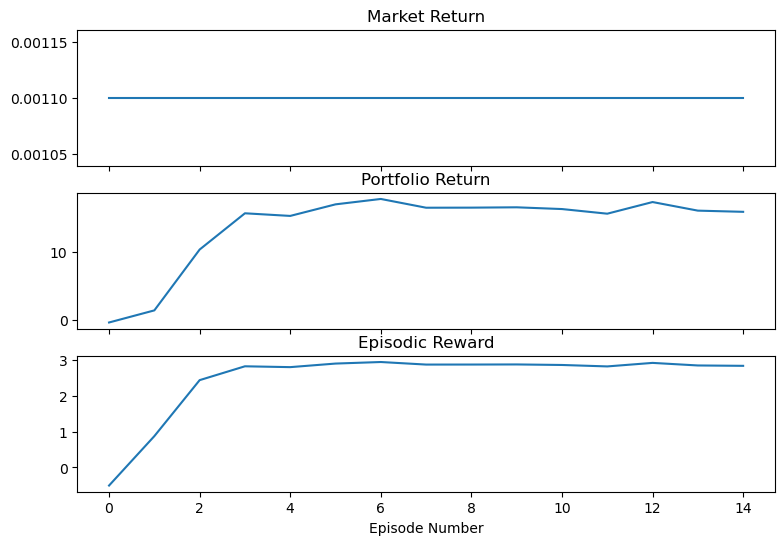

In [10]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

fig, axs = plt.subplots(3, 1, figsize=(9, 6), sharex=True)
axs[0].plot(all_metrics["Market Return"], label="Market Return")
axs[0].set_title("Market Return")
axs[1].plot(all_metrics["Portfolio Return"], label="Portfolio Return")
axs[1].set_title("Portfolio Return")
axs[2].plot(all_metrics["episodic_reward"], label="Episodic Reward")
axs[2].set_title("Episodic Reward")
axs[2].set_xlabel("Episode Number")
plt.show()

In [11]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
history_dfs = []
for i in range(10):
    x_c, y_c = stationary_dgp(N=N, x0=x0, mu=mu_epsilon, random_state=i*1234)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
    # spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

    fe = FeatureEngineering(_df)
    _df = fe.build_features(feature_config)
    
    env_test = gym.make("TradingEnv",
            name= "stationary_dgp_qlearning",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            dynamic_feature_functions = [dynamic_feature_last_position_taken],
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))
    history_dfs.append(pd.DataFrame(list(env_test.unwrapped.historical_info)))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.22%   |   Portfolio Return : 2029.45%   |   Position Changes : 2035   |   Episode Length : 4166   |   
Market Return : -0.02%   |   Portfolio Return : 1967.66%   |   Position Changes : 1973   |   Episode Length : 4166   |   
Market Return :  0.39%   |   Portfolio Return : 1824.07%   |   Position Changes : 1958   |   Episode Length : 4166   |   
Market Return : -0.10%   |   Portfolio Return : 1894.69%   |   Position Changes : 1984   |   Episode Length : 4166   |   
Market Return :  0.13%   |   Portfolio Return : 1910.19%   |   Position Changes : 2032   |   Episode Length : 4166   |   
Market Return : -0.06%   |   Portfolio Return : 1887.99%   |   Position Changes : 1990   |   Episode Length : 4166   |   
Market Return :  0.01%   |   Portfolio Return : 2302.04%   |   Position Changes : 2005   |   Episode Length : 4166   |   
Market Return : -0.02%   |   Portfolio Return : 2019.82%   |   Position Changes : 2022   |   Episode Length : 4166   |   
Market Return : -0.24%  

In [12]:
# env_test.unwrapped.save_for_render(dir = "render_logs")

historical_info_df = history_dfs[-1]
historical_info_df.columns

Index(['idx', 'step', 'date', 'position_index', 'position', 'real_position',
       'data_open', 'data_volume', 'data_close', 'data_high', 'data_low',
       'portfolio_valuation', 'portfolio_distribution_asset',
       'portfolio_distribution_fiat', 'portfolio_distribution_borrowed_asset',
       'portfolio_distribution_borrowed_fiat',
       'portfolio_distribution_interest_asset',
       'portfolio_distribution_interest_fiat', 'reward'],
      dtype='object')

In [13]:
def extract_signals(historical_info_df: pd.DataFrame):
    """
    Given a DataFrame with columns ['data_close', 'position'], 
    shift and detect only the entry/exit transitions.
    Returns (buy_df, sell_df, exit_df).
    """
    df = historical_info_df[['data_close', 'position']].copy()
    df['position'] = df['position'].shift(-1)
    df['prev_position'] = df['position'].shift(1)

    buy_df = df[(df['position'] == 1) & (df['prev_position'] != 1)]
    sell_df = df[(df['position'] == -1) & (df['prev_position'] != -1)]
    exit_df = df[(df['position'] == 0) & (df['prev_position'] != 0)]

    return buy_df, sell_df, exit_df


def build_fig(historical_info_df: pd.DataFrame,
              buy_df: pd.DataFrame,
              sell_df: pd.DataFrame,
              exit_df: pd.DataFrame):
    """
    Build a 2-row subplot:
     - Row 1: candlestick + buy/sell/exit markers
     - Row 2: portfolio valuation line
    Returns the Plotly Figure.
    """
    sample = historical_info_df
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.05,
        row_heights=[0.7, 0.3],
        subplot_titles=["Price Candlestick", "Portfolio Value"]
    )

    # Row 1: Candlestick
    fig.add_trace(go.Candlestick(
        x=sample.index,
        open=sample['data_open'],
        high=sample['data_high'],
        low=sample['data_low'],
        close=sample['data_close'],
        name="Price"
    ), row=1, col=1)

    # Markers
    marker_specs = {
        'Buy':    dict(df=buy_df,   color='green', symbol='triangle-up'),
        'Sell':   dict(df=sell_df,  color='red',   symbol='triangle-down'),
        'Exit':   dict(df=exit_df,  color='blue',  symbol='circle'),
    }
    for name, spec in marker_specs.items():
        fig.add_trace(go.Scatter(
            x=spec['df'].index,
            y=spec['df']['data_close'],
            mode='markers',
            marker=dict(color=spec['color'], size=10, symbol=spec['symbol']),
            name=name
        ), row=1, col=1)

    # Row 2: Portfolio value
    fig.add_trace(go.Scatter(
        x=sample.index,
        y=sample['portfolio_valuation'],
        mode='lines',
        line=dict(color='blue'),
        name="Portfolio Value"
    ), row=2, col=1)

    # Layout
    fig.update_layout(
        height=500,
        margin=dict(t=40, b=20, l=40, r=20),
        xaxis_rangeslider_visible=False,
        xaxis2_rangeslider_visible=False  # if you ever disable or have more subplots
    )
    return fig

In [14]:
buy_df_qlearning, sell_df_qlearning, exit_df_qlearning = extract_signals(historical_info_df)
fig_qlearning = build_fig(
    historical_info_df,
    buy_df_qlearning,
    sell_df_qlearning,
    exit_df_qlearning
)
fig_qlearning.show()

In [16]:
def plot_signals_distribution(signals_df, threshold):
    """
    Plots a violin + jittered stripplot of data_close by position,
    with a horizontal line at `threshold`.
    """
    plt.figure(figsize=(8, 6))
    # Violin (no inner box)
    sns.violinplot(
        data=signals_df,
        x='position',
        y='data_close',
        inner=None,
        color=".8"
    )
    # Jittered points
    sns.stripplot(
        data=signals_df,
        x='position',
        y='data_close',
        jitter=0.2,
        size=4,
        alpha=0.6
    )
    # Threshold line
    plt.axhline(threshold, color='r', linestyle='--', label=f'y = {threshold}')
    plt.legend()

    plt.title('Distribution + Jittered Points by Position')
    plt.tight_layout()
    plt.show()


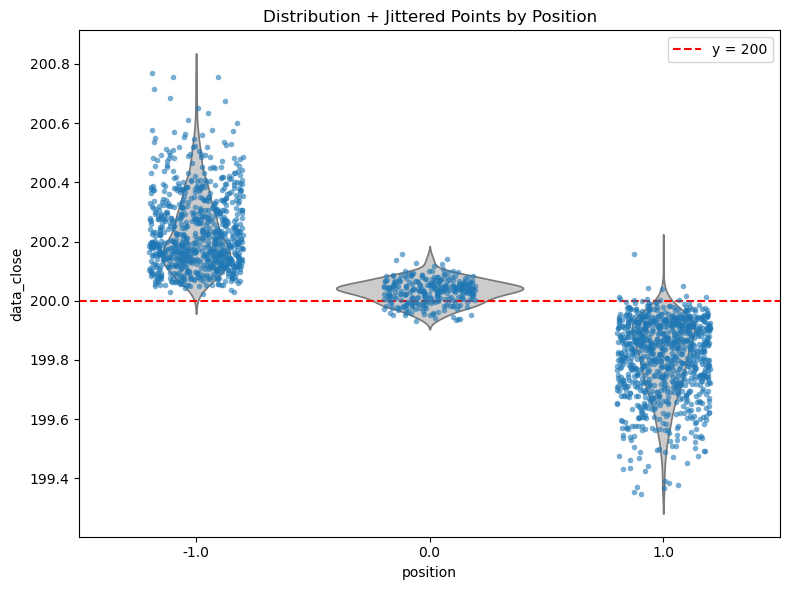

In [17]:
signals_df_qlearning = pd.concat([buy_df_qlearning, sell_df_qlearning, exit_df_qlearning])
plot_signals_distribution(signals_df_qlearning, threshold=mu_epsilon)

### Demo: Using XGBoost model-based Q-Learning on the spread (with no feature engineering)

In [18]:
# build features
df_train = df.copy()

feature_config = [
    {'type': 'select',
     'params': {
         'cols': ['close'],
     }}
]

fe = FeatureEngineering(df_train)
fe.build_features(feature_config)
df_train = fe.df.copy()
df_train

,open,high,low,close,feature_close
2020-01-01,199.986174,200.549237,199.319746,199.802509,199.802509
2020-01-02,199.645954,200.435982,199.612046,199.948100,199.948100
2020-01-03,199.979395,200.403368,199.656875,200.142213,200.142213
2020-01-04,200.206174,200.651949,199.902046,200.274014,200.274014
2020-01-05,200.122038,200.695065,199.800625,200.171634,200.171634
...,...,...,...,...,...
2031-05-24,200.289505,200.562267,199.683165,200.403368,200.403368
2031-05-25,200.328411,200.867773,199.559922,200.168429,200.168429
2031-05-26,200.196776,200.803471,199.726151,200.041121,200.041121
2031-05-27,200.228767,200.609699,199.439465,199.930831,199.930831


In [19]:
# Define the environment
env_action_space = [-1, 0, 1] # Positions : [-1=SHORT, 0=OUT, 1=LONG]
# env_action_space = [i/10 for i in range(-10, 11)] # Positions : [-1, -0.9, -0.8, ..., 0, 0.1, 0.2, ..., 1]

env = gym.make("TradingEnv",
        name= "stationary_dgp",
        df = df_train, # Your dataset with your custom features
        positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
        trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
        borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
        dynamic_feature_functions = [dynamic_feature_last_position_taken],
        # max_episode_duration=180
    )
env.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
env.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

# Run an episode until it ends :
done, truncated = False, False
observation, info = env.reset()
print(observation)
while not done and not truncated:
    # Pick a position by its index in your position list (=[-1, 0, 1])....usually something like : position_index = your_policy(observation)
    position_index = env.action_space.sample() # At every timestep, pick a random position index from your position list (=[-1, 0, 1])
    observation, reward, done, truncated, info = env.step(0)

n_actions = env.action_space.n
n_observations = len(env.reset()[0])

[199.8025   0.    ]
Market Return :  0.11%   |   Portfolio Return : -0.12%   |   Position Changes : 1   |   Episode Length : 4166   |   


In [20]:
agent = XGBoostAgent(n_observations, n_actions)
history_metrics, _ = agent.train(env, num_episodes=20, replay_every=2)

Market Return :  0.11%   |   Portfolio Return : -27.13%   |   Position Changes : 2832   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : -23.74%   |   Position Changes : 2813   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 140.05%   |   Position Changes : 2640   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 201.01%   |   Position Changes : 2642   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 676.77%   |   Position Changes : 2384   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 634.35%   |   Position Changes : 2373   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1137.55%   |   Position Changes : 2249   |   Episode Length : 4166   |   
Market Return :  0.11%   |   Portfolio Return : 1018.50%   |   Position Changes : 2283   |   Episode Length : 4166   |   
Market Return :  0.11%   |   P

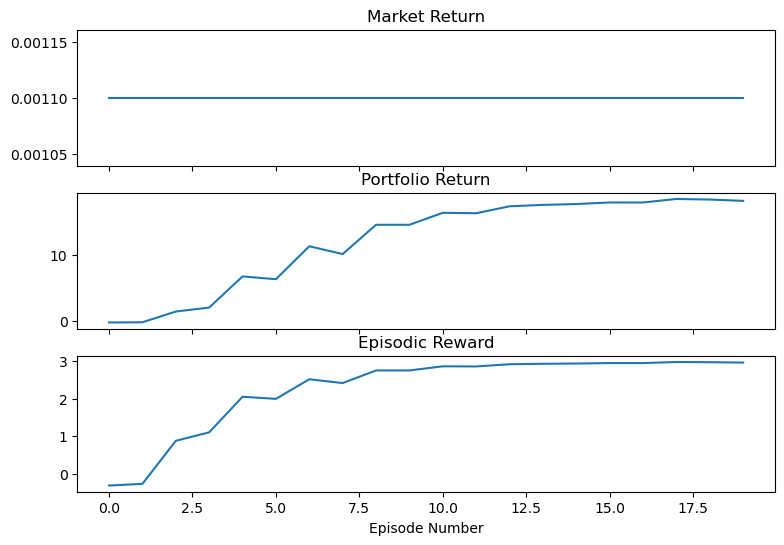

In [21]:
all_metrics = pd.DataFrame(history_metrics)
perc2float = lambda x: float(x.strip('%'))/100

all_metrics["Market Return"] = all_metrics["Market Return"].apply(perc2float)
all_metrics["Portfolio Return"] = all_metrics["Portfolio Return"].apply(perc2float)

fig, axs = plt.subplots(3, 1, figsize=(9, 6), sharex=True)
axs[0].plot(all_metrics["Market Return"], label="Market Return")
axs[0].set_title("Market Return")
axs[1].plot(all_metrics["Portfolio Return"], label="Portfolio Return")
axs[1].set_title("Portfolio Return")
axs[2].plot(all_metrics["episodic_reward"], label="Episodic Reward")
axs[2].set_title("Episodic Reward")
axs[2].set_xlabel("Episode Number")
plt.show()

In [22]:
# Evaluate the agent on a new dataset from the same data generating process
returns = []
history_dfs = []
for i in range(10):
    x_c, y_c = stationary_dgp(N=N, x0=x0, mu=mu_epsilon, random_state=i*1234)
    y_o, y_h, y_l, y_c = make_ohlc(y_c, window=window, stride=stride)
    x_o, x_h, x_l, x_c = make_ohlc(x_c, window=window, stride=stride)
    spread_o, spread_h, spread_l, spread_c = y_o - x_o, y_h - x_l, y_l - x_h, y_c - x_c
    # spread_o, spread_h, spread_l, spread_c = x_o, x_h, x_l, x_c  # test on random walk

    _df = pd.DataFrame({'open': spread_o, 'high': spread_h, 'low': spread_l, 'close': spread_c})
    _df["volume"] = 0
    _df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
    fe = FeatureEngineering(_df)
    fe.build_features(feature_config)
    _df = fe.df.copy()

    env_test = gym.make("TradingEnv",
            name= "stationary_dgp_xgboost",
            df = _df, # Your dataset with your custom features
            positions = env_action_space, # -1 (=SHORT), 0(=OUT), +1 (=LONG)
            trading_fees = 0.01/100, # 0.01% per stock buy / sell (Binance fees)
            borrow_interest_rate= 0.0003/100, # 0.0003% per timestep (one timestep = 1h here)
            dynamic_feature_functions = [dynamic_feature_last_position_taken],
        )
    env_test.unwrapped.add_metric('Position Changes', lambda history : np.sum(np.diff(history['position']) != 0) )
    env_test.unwrapped.add_metric('Episode Length', lambda history : len(history['position']) )

    env_test = agent.eval(env_test)
    returns.append(perc2float(env_test.unwrapped.get_metrics()["Portfolio Return"]))
    history_dfs.append(pd.DataFrame(list(env_test.unwrapped.historical_info)))

print(f"Average Portfolio Return: {np.mean(returns)}")
print(f"Std Portfolio Return: {np.std(returns)}")

Market Return :  0.22%   |   Portfolio Return : 1663.16%   |   Position Changes : 2044   |   Episode Length : 4166   |   
Market Return : -0.02%   |   Portfolio Return : 1800.33%   |   Position Changes : 2022   |   Episode Length : 4166   |   
Market Return :  0.39%   |   Portfolio Return : 1627.41%   |   Position Changes : 1974   |   Episode Length : 4166   |   
Market Return : -0.10%   |   Portfolio Return : 1677.55%   |   Position Changes : 2044   |   Episode Length : 4166   |   
Market Return :  0.13%   |   Portfolio Return : 1736.61%   |   Position Changes : 2117   |   Episode Length : 4166   |   
Market Return : -0.06%   |   Portfolio Return : 1580.01%   |   Position Changes : 1960   |   Episode Length : 4166   |   
Market Return :  0.01%   |   Portfolio Return : 1894.34%   |   Position Changes : 2049   |   Episode Length : 4166   |   
Market Return : -0.02%   |   Portfolio Return : 1788.29%   |   Position Changes : 2066   |   Episode Length : 4166   |   
Market Return : -0.24%  

In [23]:
# env_test.unwrapped.save_for_render(dir = "render_logs")

In [24]:
historical_info_df = history_dfs[-1]
buy_df_xgb, sell_df_xgb, exit_df_xgb = extract_signals(historical_info_df)
fig_xgb = build_fig(
    historical_info_df,
    buy_df_xgb,
    sell_df_xgb,
    exit_df_xgb
)
fig_xgb.show()

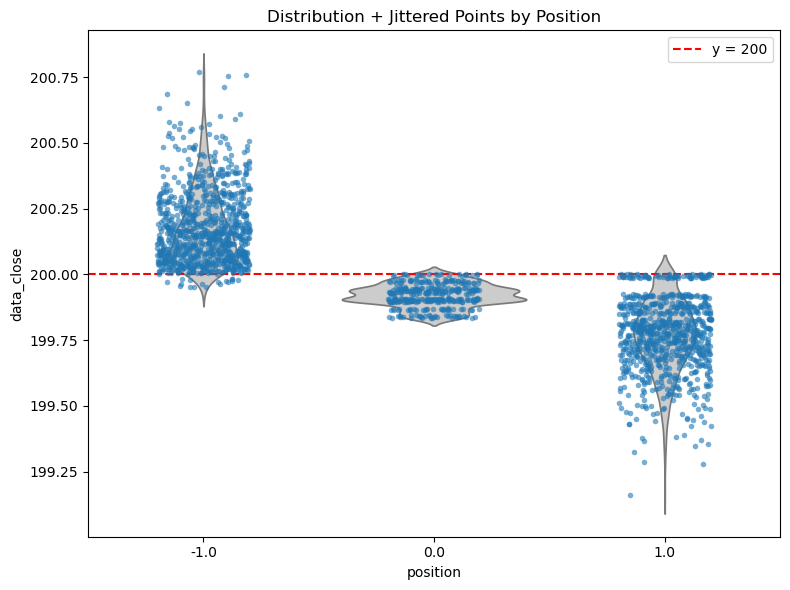

In [25]:
signals_df_xgb = pd.concat([buy_df_xgb, sell_df_xgb, exit_df_xgb])
plot_signals_distribution(signals_df_xgb, threshold=mu_epsilon)

In [26]:
len(signals_df_qlearning), len(signals_df_xgb)

(2004, 2077)

In [27]:
signals_df_qlearning["above"] = signals_df_qlearning["data_close"] > mu_epsilon
signals_df_qlearning.groupby(['position', 'above']).size().unstack(fill_value=0).rename(columns={False: f'≤ {mu_epsilon}', True: f'> {mu_epsilon}'})

above,≤ 200,> 200
position,,
-1.0,0,815
0.0,68,222
1.0,887,12


In [28]:
signals_df_xgb["above"] = signals_df_xgb["data_close"] > mu_epsilon
signals_df_xgb.groupby(['position', 'above']).size().unstack(fill_value=0).rename(columns={False: f'≤ {mu_epsilon}', True: f'> {mu_epsilon}'})

above,≤ 200,> 200
position,,
-1.0,17,901
0.0,331,7
1.0,812,9
